In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

C:\Users\computer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

#### Display the first 25 images from the training set and display the class name below each image. 

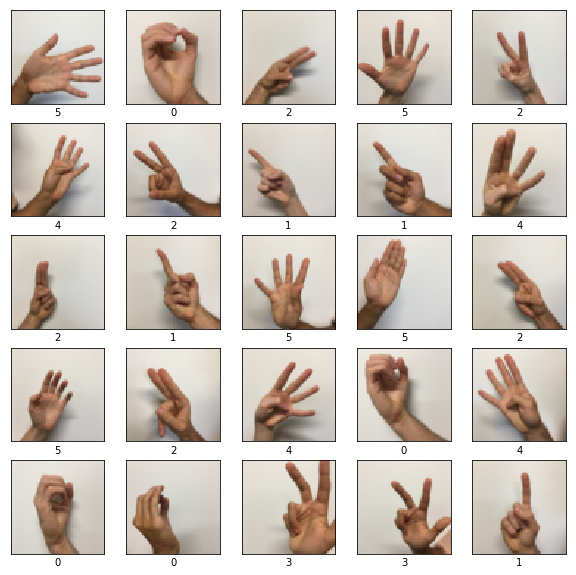

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_orig[i])
    plt.xlabel(np.squeeze(Y_train_orig[:, i]))

In [4]:
print ("number of training examples = " + str(X_train_orig.shape[1]))
print ("number of test examples = " + str(X_test_orig.shape[1]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))

number of training examples = 64
number of test examples = 64
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


#### flatten the image dataset, then normalize it by dividing by 255.

In [5]:
X_train = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train / 255.
X_test = X_test / 255.

print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (12288, 1080)
X_test shape: (12288, 120)


#### convert each label to a one-hot vector

In [6]:
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Y_train shape: (6, 1080)
Y_test shape: (6, 120)


### Create placeholders  
#### create placeholders for X and Y. This will allow us to later pass training data in when we run the session.

In [7]:
def create_placeholders(nx, ny):
    X = tf.placeholder(name = 'X_placeholder', shape = [nx, None], dtype = tf.float32)
    Y = tf.placeholder(name = 'Y_placeholder', shape = [ny, None], dtype = tf.float32)
    return X, Y

### Initializing the parameters
#### use Xavier Initialization for weights and Zero Initialization for biases

In [8]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable(name = 'W1', shape = [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable(name = 'b1', shape = [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable(name = 'W2', shape = [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable(name = 'b2', shape = [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable(name = 'W3', shape = [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable(name = 'b3', shape = [6, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

### Forward propagation in tensorflow

In [9]:
def forward_propagate(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1, X) + b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(W2, A1) + b2
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3
    
    return Z3

### Compute cost
#### It is important to know that the "logits" and "labels" inputs of tf.nn.softmax_cross_entropy_with_logits are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y.

In [10]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

### Building the model

In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, 
          num_epochs = 1500, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3
    
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    costs = [] 
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagate(X, parameters)
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters
    

#### Run the following cell to train your model

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.899366
Cost after epoch 100: 1.178147
Cost after epoch 200: 0.743206
Cost after epoch 300: 0.488414
Cost after epoch 400: 0.333639
Cost after epoch 500: 0.232248
Cost after epoch 600: 0.150025
Cost after epoch 700: 0.101945
Cost after epoch 800: 0.067172
Cost after epoch 900: 0.044780
Cost after epoch 1000: 0.029167
Cost after epoch 1100: 0.018391
Cost after epoch 1200: 0.011808
Cost after epoch 1300: 0.007394
Cost after epoch 1400: 0.003909


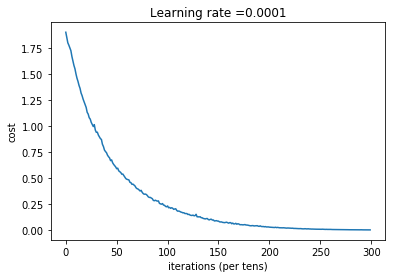

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.8833333


In [12]:
parameters = model(X_train, Y_train, X_test, Y_test)

### Test with an image

Our algorithm predicts: y = 5


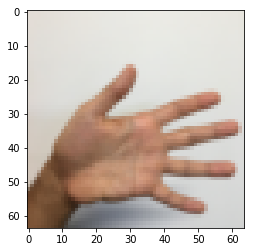

In [17]:
# We preprocess test image to fit to the algorithm.
test_image = X_train_orig[0].reshape((1, 64*64*3)).T
test_image_prediction = predict(test_image, parameters)

plt.imshow(X_train_orig[0])
print("Our algorithm predicts: y = " + str(np.squeeze(test_image_prediction)))